# Estrategia recomendacion brokers

## Autor: Lucía Saiz Lapique

__Examen__

__Gestión de Activos y Carteras__

__CUNEF__

Esta estrategia de optimización de carteras, o modelo de predicción de rendimientos, a estudiar es la estrategia de recomendación de analistas. De todos los datos proporcionados, esta estrategia utiliza únicamente los datos de recomendación por analistas de cada activo, donde las recomendaciones rondan entre 0 y 5 (0 siendo la peor nota y 5 la mejor).

Contamos con un total de 175 activos a estudiar para la creación de la cartera, además de datos históricos desde mayo de 2015 hasta mayo de 2020. Esta estrategia realiza un ranking de todos los activos en función de la recomendación que tiene cada uno y teniendo en cuenta las posiciones de cada uno a corto o largo plazo (la importancia de cada plazo depende del peso que le demos a cada una y será explicada más adelante). El objetivo no es solo optimizar las rentabilidades de las acciones seleccionadas, sino hacer pruebas a la hora de seleccionar una estrategia u otra. 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr

Importamos los datos tanto históricos como los específicos para cada estrategia.

In [19]:
datos = pd.read_excel('datos_examen2.xlsx', sheet_name = 'Datos')
datos = datos.set_index('Name')
datos

,Symbol,Price,Currency,Sector,Country,OPER_MARGIN,RETURN_ON_INV_CAPITAL,ROC_WACC_RATIO,OPERATING_ROIC,OPER_INC_TO_TOT_DEBT,...,PX_TO_BOOK_RATIO,PX_TO_CASH_FLOW,EPS_GROWTH,DVD_PAYOUT_RATIO,EQY_REC_CONS,TOT_ANALYST_REC,TOT_BUY_REC,TOT_SELL_REC,TWITTER_SENTIMENT,NEWS_SENTIMENT
Name,,,,,,,,,,,,,,,,,,,,,
L'OREAL,OR FP Equity,269.700,EUR,Cosmetics/Personal Care,FRANCE,17.745099,11.919607,1.772554,17.325215,1.836388,...,5.11651,24.2592,-4.267845,63.253283,2.967742,31,7,8,-0.175997,0.441251
VINCI SA,DG FP Equity,90.320,EUR,Engineering&Construction,FRANCE,11.180850,7.025344,1.417503,10.390774,0.168256,...,2.45154,6.70978,9.293680,51.901082,3.760000,25,14,4,-0.151347,-0.070688
BANCO BILBAO VIZCAYA ARGENTA,BBVA SQ Equity,3.527,EUR,Banks,SPAIN,29.234690,2.635223,2.318590,2.221896,NaN,...,0.478253,NaN,-35.080363,49.270218,3.093750,32,11,9,0.021949,-0.471481
BANCO SANTANDER SA,SAN SQ Equity,2.527,EUR,Banks,SPAIN,23.411659,2.868100,2.262225,1.843059,NaN,...,0.435722,NaN,-17.593246,58.667174,3.562500,32,15,5,0.004102,-0.468159
ASML HOLDING NV,ASML NA Equity,320.500,EUR,Semiconductors,NETHERLANDS,23.610829,17.030943,1.282539,18.505194,0.841185,...,10.892,42.7511,0.983607,38.866863,3.951220,41,24,4,0.311931,0.311327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CISCO SYSTEMS INC,CSCO UW Equity,47.830,USD,Telecommunications,UNITED STATES,27.394806,18.245801,2.558312,24.375592,0.576462,...,5.65259,13.0481,13050.000000,51.449961,3.800000,30,14,2,-0.447240,0.311720
EXXON MOBIL CORP,XOM UN Equity,53.080,USD,Oil&Gas,UNITED STATES,4.511646,2.064358,0.208075,3.210000,0.219104,...,1.23255,8.19717,-31.147541,103.514644,2.785714,28,3,6,-0.103257,0.082322
WALGREENS BOOTS ALLIANCE INC,WBA UW Equity,45.350,USD,Retail,UNITED STATES,3.531922,12.450000,5.120000,6.200000,0.287123,...,1.68329,5.91757,-14.792899,41.145831,2.909091,22,1,2,-0.118059,-0.257975


In [20]:
datos.columns

Index(['Symbol', 'Price', 'Currency', 'Sector', 'Country', 'OPER_MARGIN',
       'RETURN_ON_INV_CAPITAL', 'ROC_WACC_RATIO', 'OPERATING_ROIC',
       'OPER_INC_TO_TOT_DEBT', 'CUR_MKT_CAP', 'PE_RATIO', 'PX_TO_BOOK_RATIO',
       'PX_TO_CASH_FLOW', 'EPS_GROWTH', 'DVD_PAYOUT_RATIO', 'EQY_REC_CONS',
       'TOT_ANALYST_REC', 'TOT_BUY_REC', 'TOT_SELL_REC', 'TWITTER_SENTIMENT',
       'NEWS_SENTIMENT'],
      dtype='object')

Importamos también, por separado, los datos históricos de cada activo.

In [21]:
historicos = pd.read_excel('datos_examen2.xlsx', sheet_name = 'Precios acciones')
historicos['Date'] = pd.to_datetime(historicos['Date'], format="%Y-%m-%d")
historicos = historicos.set_index('Date')
observacion = historicos.index >= dt.datetime(2015, 4, 30)
historicos = historicos[(observacion)]
historicos.head()

,L'OREAL,VINCI SA,BANCO BILBAO VIZCAYA ARGENTA,BANCO SANTANDER SA,ASML HOLDING NV,KONINKLIJKE PHILIPS NV,TELEFONICA SA,TOTAL SA,AIR LIQUIDE SA,AXA SA,...,MERCK & CO. INC.,INTEL CORP.1,RAYTHEON TECHNOLOGIES CORP,VERIZON COMMUNICATIONS INC,COCA-COLA CO/THE,CISCO SYSTEMS INC.1,EXXON MOBIL CORP,WALGREENS BOOTS ALLIANCE INC.1,PFIZER INC,DOW INC
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-30,170.45,54.82,9.000,6.6449,96.71,25.655,13.640,48.485,94.0205,22.615,...,59.56,32.55,67.091,50.44,40.56,28.83,87.37,82.93,33.93,NaN
2015-05-01,170.45,54.82,9.000,6.6449,96.71,25.655,13.640,48.485,94.0205,22.615,...,59.86,33.42,68.088,50.41,40.91,29.13,88.85,83.46,34.08,NaN
2015-05-04,173.35,54.60,9.040,6.6380,96.78,25.440,13.765,48.130,95.4695,22.735,...,60.64,33.43,68.684,50.52,40.96,29.17,89.11,84.13,34.32,NaN
2015-05-05,166.70,53.76,8.825,6.4128,94.75,25.190,13.515,47.675,93.4168,22.275,...,60.49,32.64,67.870,50.09,40.75,28.89,88.61,83.14,34.12,NaN
2015-05-06,167.75,53.30,8.949,6.4816,93.67,25.080,13.520,47.845,93.9803,22.540,...,60.26,32.22,67.876,49.64,40.66,28.97,88.19,83.10,33.46,NaN


In [22]:
historicos.columns

Index(['L'OREAL', 'VINCI SA', 'BANCO BILBAO VIZCAYA ARGENTA',
       'BANCO SANTANDER SA', 'ASML HOLDING NV', 'KONINKLIJKE PHILIPS NV',
       'TELEFONICA SA', 'TOTAL SA', 'AIR LIQUIDE SA', 'AXA SA',
       ...
       'MERCK & CO. INC.', 'INTEL CORP.1', 'RAYTHEON TECHNOLOGIES CORP',
       'VERIZON COMMUNICATIONS INC', 'COCA-COLA CO/THE', 'CISCO SYSTEMS INC.1',
       'EXXON MOBIL CORP', 'WALGREENS BOOTS ALLIANCE INC.1', 'PFIZER INC',
       'DOW INC'],
      dtype='object', length=218)

In [23]:
indice = pd.read_excel('datos_examen2.xlsx', sheet_name = 'Precios Index')
indice['Date'] = pd.to_datetime(indice['Date'], format="%Y-%m-%d")
indice = indice.set_index('Date')
observacion = indice.index >= dt.datetime(2015, 4, 30)
indice = indice[(observacion)]
indice.head()

,Euro Stoxx 50 Pr,IBEX 35 INDEX,DOW JONES INDUS. AVG,MSCI WORLD,NASDAQ COMPOSITE INDEX,S&P 500 INDEX,NIKKEI 225,FTSE 100 INDEX
Date,,,,,,,,
2015-04-30,3615.59,11385.0,17840.52,1778.40,4941.424,2085.51,19520.01,6960.63
2015-05-01,3615.59,11385.0,18024.06,1787.40,5005.391,2108.29,19531.63,6985.95
2015-05-04,3632.94,11429.1,18070.40,1790.83,5016.929,2114.49,19531.63,6985.95
2015-05-05,3546.56,11115.6,17928.20,1773.42,4939.327,2089.46,19531.63,6927.58
2015-05-06,3558.03,11163.6,17841.98,1772.82,4919.645,2080.15,19531.63,6933.74


Seleccionamos únicamente la variable de recomendaciones de todos los datos proporcionados para crear el ranking y los pesos ya que, en esta estrategia, son los únicos que se deben aplicar. Para ello, creamos un nuevo dataframe que será utilizado de ahora en adelante como los datos originales.

In [24]:
recom = datos[['EQY_REC_CONS']]
recom.index = datos.index
recom.head()

,EQY_REC_CONS
Name,
L'OREAL,2.967742
VINCI SA,3.760000
BANCO BILBAO VIZCAYA ARGENTA,3.093750
BANCO SANTANDER SA,3.562500
ASML HOLDING NV,3.951220


In [25]:
ranking = recom.rank(ascending=False) 
ranking.head()

,EQY_REC_CONS
Name,
L'OREAL,205.0
VINCI SA,145.0
BANCO BILBAO VIZCAYA ARGENTA,196.5
BANCO SANTANDER SA,164.5
ASML HOLDING NV,116.0


## Estrategia: mismo peso en corto que en largo

Seleccionamos unos pesos para el largo y corto plazo y se lo aplicamos a cada variable en función del ranking anterior. En este caso, se selecciona aplicarle __el mismo peso al corto plazo que al largo__ pues aunque en el ejercicio no se especifique, es la importancia que se le ha aplicado al resto de estrategias, y así podemos mantener la estructura. Decidimos, además,  apalancar esta estrategia (aplicando pesos de 200%) para obtener mejores resultados, pues de hacer lo contrario, con el tiempo, esta estrategia no sería tan óptima.

Una vez seleccionada nuestra estrategia, decidimos aplicarle una importancia de 20 y 20 a cada plazo (corto y largo respectivamente) para que tengan el mismo peso y que así, la estrategia sea neutral al mercado. Además, se le aplica mayor peso al largo (+200%) y menos al corto (-200%) para optimizar la estrategia y que gane valor.

In [26]:
corto = 50.0
largo = 50.0
peso_corto = -2
peso_largo = 2

A continuación, generamos un dataframe con los pesos finales de cada activo, teniendo en cuenta si tienen un mejor ranking en corto o en el largo plazo.



In [27]:
cuenta = datos.Symbol.count()
cuenta

217

In [29]:
lista = []
for i in ranking['EQY_REC_CONS']:
    m = []
    if i <= largo: 
        pesos = peso_largo/largo
        m.append(pesos)
    elif i >= (cuenta + 1 - corto): 
        pesos = peso_corto/corto
        m.append(pesos)
    else:
        pesos = 0
        m.append(pesos)
    lista.extend(m)
    weights = pd.DataFrame(lista, columns = ['EQY_REC_CONS'])

Obtenemos así los pesos finales y añadimos la columna de símbolos del dataframe inicial para ponerlo como índice. 

In [30]:
weights['Name'] = datos.index
weights = weights.set_index('Name')
weights.head()

,EQY_REC_CONS
Name,
L'OREAL,-0.04
VINCI SA,0.00
BANCO BILBAO VIZCAYA ARGENTA,-0.04
BANCO SANTANDER SA,0.00
ASML HOLDING NV,0.00


## Datos finales de la estrategia

Para la parte final de este estudio, debemos tener en cuenta los datos históricos de cada activo importados al principio del análisis. Estimamos el cambio de porcentaje de cada activo para obtener las renntabilidades diarias de cada una y así obtener los datos finales con los que generaremos la cartera óptima.

In [31]:
historicos.dropna(inplace = True, axis = 1)
df = historicos.pct_change().dropna()
df.head()

,L'OREAL,VINCI SA,BANCO BILBAO VIZCAYA ARGENTA,BANCO SANTANDER SA,ASML HOLDING NV,KONINKLIJKE PHILIPS NV,TELEFONICA SA,TOTAL SA,AIR LIQUIDE SA,AXA SA,...,AMERICAN EXPRESS CO,MERCK & CO. INC.,INTEL CORP.1,RAYTHEON TECHNOLOGIES CORP,VERIZON COMMUNICATIONS INC,COCA-COLA CO/THE,CISCO SYSTEMS INC.1,EXXON MOBIL CORP,WALGREENS BOOTS ALLIANCE INC.1,PFIZER INC
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002970,0.005037,0.026728,0.014860,-0.000595,0.008629,0.010406,0.016939,0.006391,0.004421
2015-05-04,0.017014,-0.004013,0.004444,-0.001038,0.000724,-0.008380,0.009164,-0.007322,0.015412,0.005306,...,0.007724,0.013030,0.000299,0.008753,0.002182,0.001222,0.001373,0.002926,0.008028,0.007042
2015-05-05,-0.038362,-0.015385,-0.023783,-0.033926,-0.020975,-0.009827,-0.018162,-0.009454,-0.021501,-0.020233,...,-0.005621,-0.002474,-0.023631,-0.011851,-0.008511,-0.005127,-0.009599,-0.005611,-0.011768,-0.005828
2015-05-06,0.006299,-0.008557,0.014051,0.010729,-0.011398,-0.004367,0.000370,0.003566,0.006032,0.011897,...,0.000128,-0.003802,-0.012868,0.000088,-0.008984,-0.002209,0.002769,-0.004740,-0.000481,-0.019343
2015-05-07,0.005067,-0.010319,0.005699,0.002129,0.002028,-0.010167,-0.003698,-0.022573,-0.003855,0.028394,...,0.007450,0.000664,0.000776,0.008339,0.001813,0.000984,-0.005696,-0.006690,0.013598,0.003586


In [32]:
def ratios(recom, weights):
    '''
        returns = dataframe que contiene las rentabilidades diarias de los activos
        weights = pesos de los activos para cada uno de los periodos de tiempo y en total
        -----------------------------------------------------------------------------------
        final = resultado de la estrategia
    '''
    
    # genero los resultados como un indice de base 100
    resultados = [100]
    
    # cojo los pesos totales de la matriz de pesos
    pesos = weights.iloc[:,-1]
    
    # voy calculado los resultados como el anterior mas 1 por la rentabilidad que se obtienen diariamente de las
    # distintas acciones y sus pesos
    for i in range(1, len(recom)):
        
        value = resultados[i-1] * (1 + (recom.iloc[i] * pesos).sum())
        
        resultados.append(value)
    
    # meto en un dataframe para devovler el resultado final y asigno las fechas coo indice
    final = pd.DataFrame(resultados, columns=['Recommendation'])  
    final.set_index(recom.index, inplace=True)
        
    return final

En el dataframe a continuación, podemos observar el resultado de esta estrategia y la graficamos a continuación. Como podemos observar, el resultado ha aumentado considerablemente en 5 años.

In [33]:
final = ratios(df, weights)
final

,Recommendation
Date,
2015-05-01,100.000000
2015-05-04,99.268981
2015-05-05,99.492990
2015-05-06,99.288724
2015-05-07,100.001805
...,...
2020-06-01,313.097609
2020-06-02,307.423462
2020-06-03,302.175610


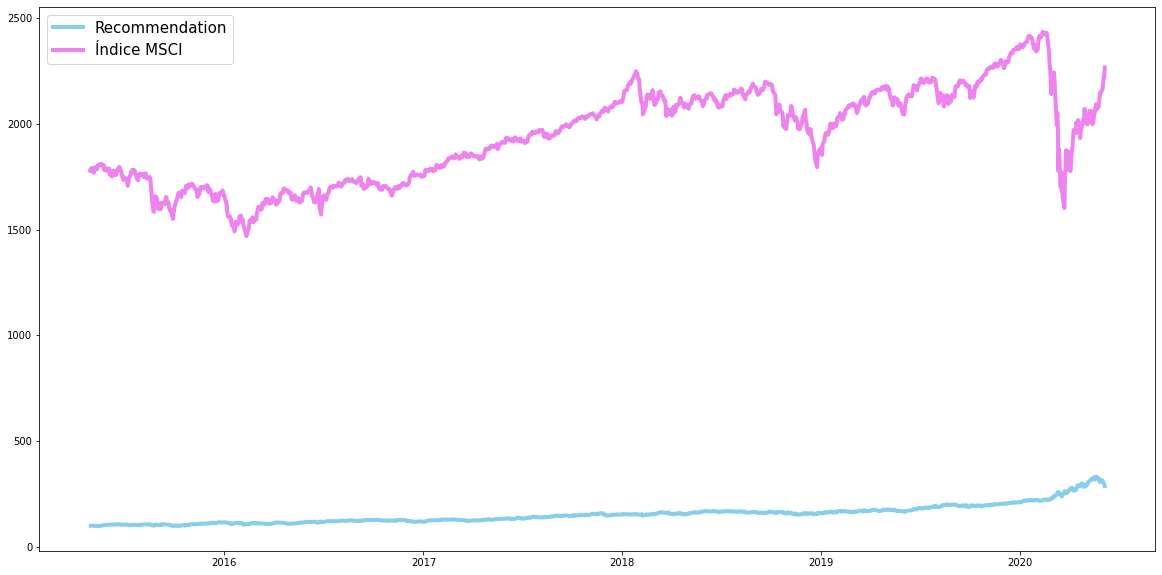

In [34]:
plt.figure(figsize=(20,10))
plt.plot(final.index, final['Recommendation'], marker='', markerfacecolor='blue', markersize=12, color='skyblue', 
         linewidth=4, label ='Recommendation')
plt.plot(indice["MSCI WORLD"], marker='', markerfacecolor='violet', markersize=12, color='violet', 
         linewidth=4, label ='Índice MSCI')
plt.legend(prop={"size":15}, loc="upper left")

Podemos concluir que la selección de pesos para los datos en cuestión es correcta (al aplicar el mayor peso al largo que al corto plazo o viceversa, los resultados eran peores y la subida era mucho menos estable, es decir, que había más volatilidad). Sin embargo, en comparación con el índice seleccionado, nuestra estrategia se mantiene prácticamente constante, es decir, que es neutral al mercado.

In [35]:
final.to_csv('Estrategia_Recommendation_final.csv')